In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

In [3]:
ref_literature = datasets.reference_publications(taxon)

In [4]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [5]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 125 ms
Wall time: 134 ms


# EBI-GXA

In [6]:
%%time

taxon = 9606

gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

ref_genes = gene_info[
    (gene_info['type_of_gene']=='protein-coding') &
    (gene_info['nomenclature_status']=='O')   # Carries an official gene symbol
]['gene_ncbi']

de = ebi.gxa(
    'de_{}_entrez'.format(taxon),
    columns=['comparison_key', 'gene_ncbi', 'p-value', 'log2foldchange']
)

de = de.drop_duplicates(subset=['comparison_key', 'gene_ncbi'], keep='first')

contrasts = ebi.gxa(
    'contrasts',
    columns=['comparison_key', 'experiment']
)

studies = ebi.gxa(
    'studies',
    columns=['experiment', 'qualifier', 'value']
)

study_types = studies[
    studies['qualifier'].str.contains('[AEExperimentType]', regex=False)
].drop_duplicates()
study_types['value'] = study_types['value'].str.strip(' ').str.strip('"')
study_types = study_types[['experiment', 'value']].rename(columns={'value': 'type'})
study_types = study_types.drop_duplicates()

study_types = study_types.drop_duplicates('experiment', keep=False)

study_types = study_types[
    study_types['type'].isin(
        [
           'transcription profiling by array',
           'RNA-seq of coding RNA' 
        ]
    )
].replace(
    {
       'transcription profiling by array': 'array',
       'RNA-seq of coding RNA': 'rna_seq' 
    }
)

main = pd.merge(
    de,
    pd.merge(
        contrasts,
        study_types
    )[['comparison_key', 'type']]
)

main = main[main['gene_ncbi'].isin(ref_genes)]

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)


CPU times: total: 21.5 s
Wall time: 21.9 s


In [22]:
studies.loc[(studies['qualifier'] == 'PubMed ID') | 
        (studies['qualifier'] == 'Pubmed ID') | 
        (studies['qualifier'] == 'pubmedID') | 
        (studies['qualifier'] == 'PubMed ID       ') | 
        (studies['qualifier'] == '''"Pubmed ID"''') | 
        (studies['qualifier'] == 'PubMedID') | 
        (studies['qualifier'] == 'PubMed Id') | 
        (studies['qualifier'] == 'PubmedID') |
        (studies['qualifier'] == 'PubMed ID '), ['qualifier']] = 'pubmed_id'

pubmed_ids_df  = studies[studies['qualifier'] == 'pubmed_id']

pubmed_ids_df = pd.merge(contrasts, pubmed_ids_df, how='left').rename(columns={'value':'pubmed_id'})

In [23]:
pubmed_ids_df['pubmed_id'].value_counts()

28892060    115
24885658     65
31806758     63
17394647     60
23180784     52
           ... 
26891258      1
23327667      1
17420462      1
22383093      1
18156220      1
Name: pubmed_id, Length: 2550, dtype: int64

In [24]:
pubmed_ids_df[pubmed_ids_df['comparison_key'].isin(np.unique(main['comparison_key']))]['pubmed_id'].value_counts()

28892060    110
24885658     65
23935999     31
25314013     31
16478798     24
           ... 
25397880      1
25488971      1
23254957      1
21810943      1
21928115      1
Name: pubmed_id, Length: 976, dtype: int64

In [25]:
%%time
pubmed_ids_df = pubmed_ids_df[(pubmed_ids_df['comparison_key'].isin(np.unique(main['comparison_key']))) & 
              (pubmed_ids_df['pubmed_id'].isin(gene2pubmed['pubmed_id'].astype(str)))].dropna()\

pubmed_ids_df['pubmed_id'] = pubmed_ids_df['pubmed_id'].astype(int)

CPU times: total: 906 ms
Wall time: 905 ms


In [29]:
pubmed_ids_df['pubmed_id'].value_counts()

22833572    22
25968456    10
25475719    10
24971610     8
22970192     7
            ..
20179017     1
23922103     1
23610125     1
23267084     1
24086395     1
Name: pubmed_id, Length: 252, dtype: int64

In [26]:
%%time
fdr_thresh = 0.05
de_cond = (main['p-value'] < fdr_thresh)
new_main = pd.merge(main[de_cond], pubmed_ids_df[['comparison_key', 'pubmed_id']])

CPU times: total: 656 ms
Wall time: 665 ms


In [27]:
new_main['pubmed_id'].drop_duplicates()

0          22991305
6560       23024189
6700       23707782
8316       23824327
9988       23871666
             ...   
1407653    24971610
1415694    26313692
1424187    25648896
1428406    26735015
1432477    23825313
Name: pubmed_id, Length: 250, dtype: int32

In [10]:
new_main['pubmed_id'].drop_duplicates().to_csv('../data/transcriptomics_pubmed_ids.csv', index=False)

In [14]:
%%time
icite = nih.icite(dataset='citations')

CPU times: total: 23.2 s
Wall time: 26.9 s


In [21]:
def get_genes(main, fdr_thresh = 0.05):
    # apply filters and p-value threshold here
    de_cond = (main['p-value'] <= fdr_thresh)
    gwas = pd.merge(main[de_cond], pubmed_ids_df[['comparison_key', 'pubmed_id']])
    
    print(str(len(set(gwas['pubmed_id'].values))) + ' transcriptomics articles')

    de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )

    np.random.seed(49)
    n_samp = 100
    de_sets = []
    de_mentioned_sets = []
    de_mentioned_sets_null = []
    de_citations_mentioned_sets = []
    citations_mentioned_sets = []
    for comparison_key in np.unique(gwas['pubmed_id'].values):
        de_list = de_dict.get(comparison_key)

        if de_dict_mentioned_genes.get(comparison_key):
            de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key)
        else:
            de_list_mentioned_genes = set()

        for n_n in range(n_samp):
            de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                               replace=False, size=len(de_list_mentioned_genes & de_list))))

        de_sets.append(de_list)
        de_mentioned_sets.append(de_list_mentioned_genes)
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)

    icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()

    icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')

    icite_slice = pd.merge(gwas[['gene_ncbi', 'pubmed_id']].drop_duplicates(), 
                     icite_slice, 
                     left_on='pubmed_id', right_on='referenced')

    icite_slice = icite_slice[icite_slice['gene_ncbi_x'] == icite_slice['gene_ncbi_y']]

    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    pad = 0.2

    prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

    de_list = set(gwas['gene_ncbi']) & prot_genes #.union(*de_sets) & prot_genes
    de_list_mentioned_genes = de_list & set(gene2pubmed[gene2pubmed['pubmed_id'].isin(gwas['pubmed_id'])]['gene_ncbi']) & prot_genes
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null) & prot_genes
    de_citations_mentioned_sets = de_list & set(icite_slice['gene_ncbi_y'])
    #itations_mentioned_sets = set().union(*citations_mentioned_sets) & prot_genes
    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')

    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes_null]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes]).fillna(0.0) + 1)[0].values, 
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_citations_mentioned_sets]).fillna(0.0) + 1)[0].values]

    ax.boxplot(data, widths=2*pad-(pad/4), positions=np.arange(len(data))+1, whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2), 
               whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

    ax.set_xlim([1-2.5*pad, 5+2.5*pad])
    ax.set_yscale('log')
    ax.set_xticks([1,2,3,4,5], labels=['all protein-\ncoding genes',
                                     'transcriptomics hits', 
                                     'null expectation',
                                   'transcriptomics hits\npromoted to\ntitle/abstract', 
                                   'transcriptomics hits\npromoted to\ntitle/abstract\nin citing papers'])

    df_array = []
    for gene_set, label in zip([prot_genes, 
                de_list, 
                de_list_mentioned_genes_null, 
                de_list_mentioned_genes, 
                de_citations_mentioned_sets],
                       ['genome', 
                        'hits', 
                        'mentioned_hits_null',
                        'mentioned_hits', 
                        'citations_mentioned_hits']):
        temp_df = pd.DataFrame({'gene_ncbi':list(gene_set)})
        temp_df['set'] = label
        df_array.append(temp_df)
    temp_df = pd.concat(df_array)

    temp_df.to_csv('../data/transcriptomics_hits_' + str(fdr_thresh) + '.csv', index=False)

250 transcriptomics articles
235 transcriptomics articles
219 transcriptomics articles
192 transcriptomics articles
171 transcriptomics articles


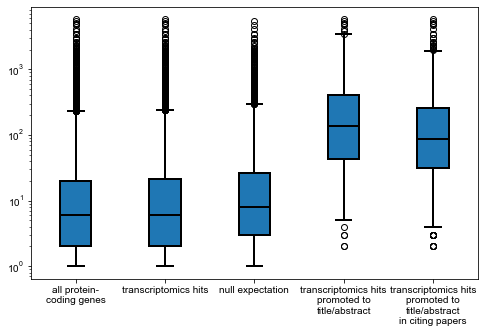

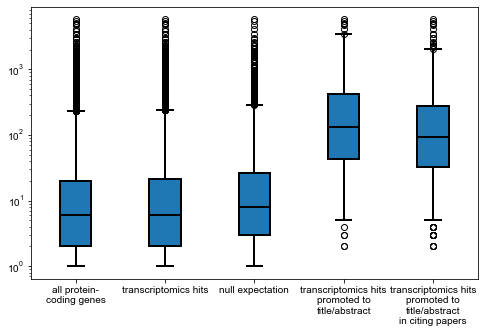

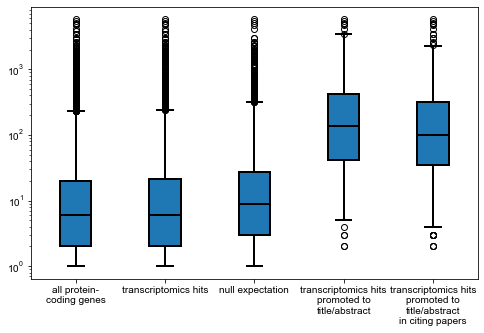

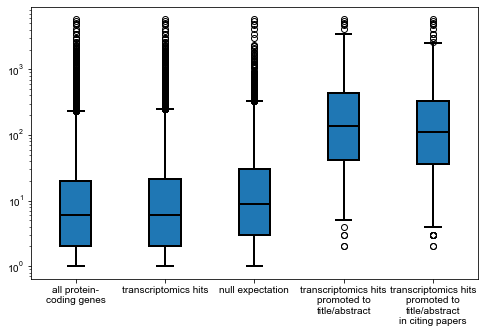

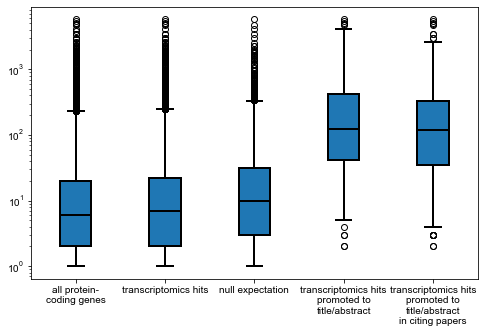

In [23]:
get_genes(main, fdr_thresh=0.05)
get_genes(main, fdr_thresh=0.01)
get_genes(main, fdr_thresh=0.001)
get_genes(main, fdr_thresh=0.0001)
get_genes(main, fdr_thresh=0.00001)

Fold-changes predict elevation to title/abstract?

In [106]:
def get_genes_fc(main, fdr_thresh = 0.05):
    # apply filters and p-value threshold here
    de_cond = (main['p-value'] <= fdr_thresh)
    
    single_pubmed = (
    pubmed_ids_df['pubmed_id'].value_counts()
        [pubmed_ids_df['pubmed_id'].value_counts() == 1].index
    )
    
    
    gwas = pd.merge(main[de_cond], 
                    pubmed_ids_df[pubmed_ids_df['pubmed_id'].isin(single_pubmed)][['comparison_key', 'pubmed_id']])
    print(str(len(set(gwas['pubmed_id'].values))) + ' transcriptomics articles')
    gwas['up_reg'] = gwas['log2foldchange'] > 0
    
    de_dict = gwas.groupby(['pubmed_id', 'up_reg'])['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )
    
    gwas['mentioned'] = [de_dict_mentioned_genes.get(comparison_key) for comparison_key in gwas['pubmed_id']]
    gwas['gene_in_mentioned'] = [gene in sett for gene, sett in zip(gwas['gene_ncbi'], gwas['mentioned'])]
    
    gwas_merge = pd.merge(gwas, gene2pubmed, on='pubmed_id')
    gwas_merge = gwas_merge[gwas_merge['gene_ncbi_x'] == gwas_merge['gene_ncbi_y']]
    return gwas

In [111]:
gwas = get_genes_fc(main, fdr_thresh=0.05)
gwas.groupby(['gene_in_mentioned', 'up_reg']).count()

129 transcriptomics articles


comparison_key  gene_ncbi  p-value  log2foldchange    type  pubmed_id  mentioned
gene_in_mentioned up_reg                                                                                  
False             False           165099     165099   165099          165099  165099     165099     165099
                  True            166637     166637   166637          166637  166637     166637     166637
True              False               42         42       42              42      42         42         42
                  True                40         40       40              40      40         40         40

In [47]:
de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )

In [81]:
gwas_merge = get_genes_fc(main, fdr_thresh=0.05)

130 articles


C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log2foldchange', ylabel='Density'>

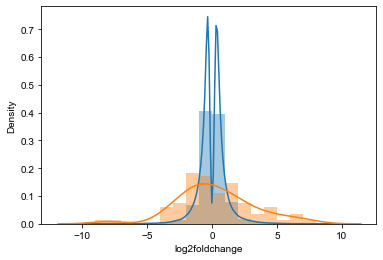

In [104]:
bins = np.arange(-12,12,1)
sns.distplot(gwas['log2foldchange'], bins=bins)
sns.distplot(gwas[gwas['gene_in_mentioned']]['log2foldchange'], bins=bins)

In [95]:
np.log2(gwas_merge['log2foldchange'])

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


4585        NaN
6966        NaN
10735     0.585
13708       NaN
18837     2.202
          ...  
413886      NaN
417283   -1.000
419955      NaN
422394      NaN
428707    0.585
Name: log2foldchange, Length: 82, dtype: float64

In [60]:
gwas['mentioned'] = [de_dict_mentioned_genes.get(comparison_key) for comparison_key in gwas['pubmed_id']]

In [61]:
gwas['gene_in_mentioned'] = [gene in sett for gene, sett in zip(gwas['gene_ncbi'], gwas['mentioned'])]

In [68]:
gwas.groupby(['gene_in_mentioned', 'up_reg']).count()

comparison_key  gene_ncbi  p-value  log2foldchange    type  pubmed_id  mentioned
gene_in_mentioned up_reg                                                                                  
False             False           165099     165099   165099          165099  165099     165099     165099
                  True            166637     166637   166637          166637  166637     166637     166637
True              False               42         42       42              42      42         42         42
                  True                40         40       40              40      40         40         40

In [77]:
gene2pubmed

,pubmed_id,gene_ncbi
0,87,27
1,87,170589
2,2009,8566
6,18198,92086
7,18469,1841
...,...,...
844056,33228346,6387
844057,33228346,7852
844062,33228505,1535
844063,33228505,4353
